# **Install libraries**

In [ ]:
!pip install mtcnn
!pip install pillow
!pip install flask-ngrok

     |████████████████████████████████| 2.3MB 8.1MB/s 


# **Import libraries**

In [ ]:
import os
import io
import cv2
import shutil
import random
import sqlite3
import numpy as np
from PIL import Image
from mtcnn import MTCNN
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from matplotlib.patches import Rectangle
from scipy.spatial.distance import cosine
from google.colab.patches import cv2_imshow
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# **Download cropped face dataset**

In [ ]:
!rm -r /content/sample_data
!wget https://zenodo.org/record/815657/files/P1E.tar.xz
!wget https://zenodo.org/record/815657/files/P1L.tar.xz
!wget https://zenodo.org/record/815657/files/P2E.tar.xz
!wget https://zenodo.org/record/815657/files/P2L.tar.xz

--2021-03-06 05:12:25--  https://zenodo.org/record/815657/files/P1E.tar.xz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66406324 (63M) [application/octet-stream]
Saving to: ‘P1E.tar.xz’

P1E.tar.xz          100%[===================>]  63.33M  18.6MB/s    in 4.3s    

2021-03-06 05:12:30 (14.6 MB/s) - ‘P1E.tar.xz’ saved [66406324/66406324]

--2021-03-06 05:12:30--  https://zenodo.org/record/815657/files/P1L.tar.xz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92345768 (88M) [application/octet-stream]
Saving to: ‘P1L.tar.xz’

P1L.tar.xz          100%[===================>]  88.07M  17.6MB/s    in 5.7s    

2021-03-06 05:12:37 (15.4 MB/s) - ‘P1L.tar.xz’ saved [92345768/92345768]

--2021-03-06 05:12:37--  https://zenodo.org/record/8

# **Extract cropped faces to -> /content/data/**

In [ ]:
!rm -r /content/data
!mkdir /content/data
!tar -xf /content/P1E.tar.xz -C /content/data
!tar -xf /content/P1L.tar.xz -C /content/data
!tar -xf /content/P2E.tar.xz -C /content/data
!tar -xf /content/P2L.tar.xz -C /content/data

rm: cannot remove '/content/data': No such file or directory


**Test Images**

In [ ]:
! wget https://zenodo.org/record/815657/files/P1E_S1.tar.xz

--2021-03-06 05:19:57--  https://zenodo.org/record/815657/files/P1E_S1.tar.xz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385315324 (367M) [application/octet-stream]
Saving to: ‘P1E_S1.tar.xz’

P1E_S1.tar.xz       100%[===================>] 367.46M  9.87MB/s    in 35s     

2021-03-06 05:20:33 (10.6 MB/s) - ‘P1E_S1.tar.xz’ saved [385315324/385315324]



In [ ]:
!mkdir /content/test
!tar -xf P1E_S1.tar.xz -C /content/test/
!tar -xf /content/test/P1E_S1_C1.tar.xz -C /content/test/
!tar -xf /content/test/P1E_S1_C2.tar.xz -C /content/test/
!tar -xf /content/test/P1E_S1_C3.tar.xz -C /content/test/
!rm /content/test/*.xz

# **Classes**

In [ ]:
class ImagePreprocessing:

  def hist_equ(self,image):
    pixels = cv2.imread(image,0)
    x=cv2.equalizeHist(pixels)
    pixels = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    cv2.imwrite(image, pixels)

  def crop_image(self,image,result_list):
    pixels = cv2.imread(image,0)
    data = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
    
    padd = 10; max = 0; max_x=0; max_y=0; max_width=0; max_height=0

    for result in result_list:
      x, y, width, height = result['box']
      if (width*height>max):
        max_x, max_y, max_width, max_height = result['box']  
        max = width*height
    
    cv2.imwrite(image, data[max_y-padd+1:max_y+max_height+padd, max_x-padd+1:max_x+max_width+padd])

  def image_resize(self,image):
    img = Image.open(image)
    newsize = (224, 224) 
    img = img.resize(newsize)
    img.save(image)

**Show the effect of histogram Equalization**


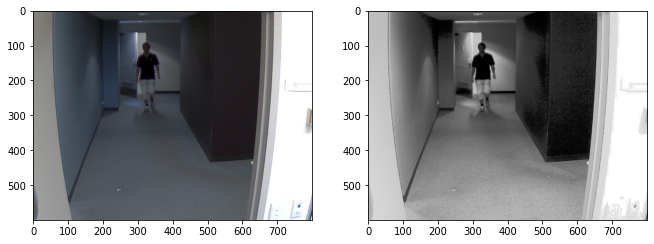

In [ ]:
preObj = ImagePreprocessing()
img = '/content/test/P1E_S1_C1/00000180.jpg'
img_A = mpimg.imread(img)

preObj.hist_equ(img)

%matplotlib inline

rcParams['figure.figsize'] = 11 ,8
img_B = mpimg.imread(img)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

In [ ]:
class FaceDetection:

  def mtcnn_facedetect(self,image):
    pixels = cv2.imread(image,3)
    detector = MTCNN()
    res = detector.detect_faces(pixels)
    return res

**Show the detection of face by MTCNN**

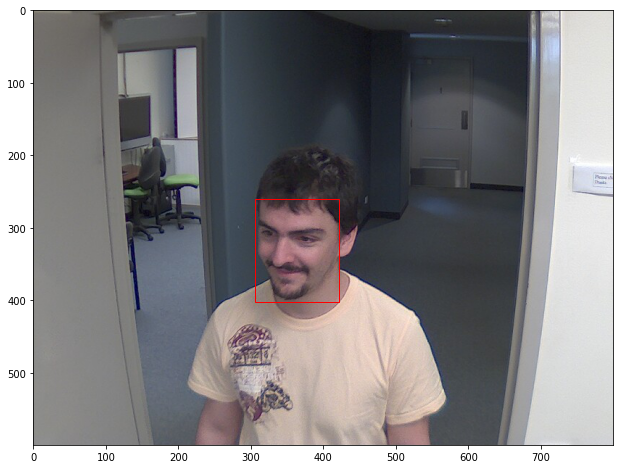

In [ ]:
faceObj = FaceDetection()
img = '/content/test/P1E_S1_C2/00000659.jpg'
faces = faceObj.mtcnn_facedetect(img)


data = plt.imread(img)
plt.imshow(data)
ax = plt.gca()

for face in faces:

  x, y, width, height = face['box']
  rect = Rectangle((x, y), width, height, fill=False, color='red')
  ax.add_patch(rect)
plt.show()

**Show cropping of image**

Face shape: (161, 134, 3)


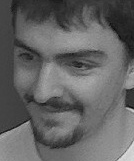

In [ ]:
preObj.crop_image(img,faces)
im_data = cv2.imread(img)
print("Face shape:",im_data.shape)
cv2_imshow(im_data)

**Show resizing of image to (224,224)**

Face shape: (224, 224, 3)


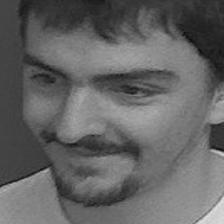

In [ ]:
preObj.image_resize(img)
im_data = cv2.imread(img)
print("Face shape:",im_data.shape)
cv2_imshow(im_data)

In [ ]:
class FeatureExtraction:

  def __init__(self):
    self.model = ResNet50(weights='imagenet', include_top=False)
    # self.model.summary()

  # Return feature vector of image
  def feature_extract(self,img):
    img_data = image.load_img(img, target_size=(224, 224))
    img_data = image.img_to_array(img_data)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    resnet50_feature = self.model.predict(img_data)
    resnet50_feature = np.array(resnet50_feature.flatten())
    return resnet50_feature

**Show the model**

In [ ]:
tempObj = FeatureExtraction()
tempObj.model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [ ]:
class Classification:

  def __init__(self,image):
    self.originalImage = image
    self.image = self.originalImage

    im = "/tmp/"+(self.image).split("/")[-1]
    shutil.copy2(self.image, im)
    self.image = im

    # Instantiate class objects
    self.preprocess_object = ImagePreprocessing()
    self.face_object = FaceDetection()
    self.feature_object = FeatureExtraction()

  # Compare the i/p vector with whole data and return best match
  def find_match(self,inp_vector):
    min = 1.1
    match =''
    for data in train:
      val = cosine(inp_vector,data[0])
      if (val<min):
        min = val
        match = data[2]
    return match
  
  def classify(self):
    # Do histogram equalization
    self.preprocess_object.hist_equ(self.image)

    # Detect face using MTCNN
    face_coordinates = self.face_object.mtcnn_facedetect(self.image)

    # Crop and resize the image to (224,224)
    self.preprocess_object.crop_image(self.image, face_coordinates)
    self.preprocess_object.image_resize(self.image)

    # Extract features using ResNet50
    inp_vector = self.feature_object.feature_extract(self.image)
    # Find the match in database
    return self.find_match(inp_vector)


In [ ]:
class CreateDataset:
  
  def __init__(self):
    self.feature_object = FeatureExtraction()
    self.root = '/content/data/'
  
  def create(self,target):
    temp = []

    for folder in target:
      print("The folder currently being processed:",folder)
      for person in sorted(os.listdir(self.root+folder)):
        if(person=='.directory'):
          continue
        for img in sorted(os.listdir(self.root+folder+'/'+person)):
          if(img=='.directory' or img=='.ipynb_checkpoints'):
            continue
          img_path = self.root+folder+'/'+person+'/'+img
          vector = self.feature_object.feature_extract(img_path)
          temp.append((vector,person,img_path))
    return temp
  

In [ ]:
class User:

  def __init__(self):
    self.image = ''
    # self.match = ''
  
  def upload(self,image):
    self.image = image
  
  def display(self,match):
    %matplotlib inline

    rcParams['figure.figsize'] = 11 ,8
    print(self.image,match)
    img_A = mpimg.imread(self.image)
    img_B = mpimg.imread(match)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_A);
    ax[1].imshow(img_B);

  def get_results(self):
    obj = Classification(self.image)
    match = obj.classify()
    self.display(match)

# **Extract vectors from images into train and test**

In [ ]:
train_folders = ['P1E_S1_C1','P1E_S1_C3','P1L_S2_C2','P2E_S3_C1','P2L_S1_C1','P2E_S1_C2','P1L_S4_C1']
test_folders = ['P1E_S1_C2','P2E_S4_C1','P1L_S4_C2']

dataObj = CreateDataset()
print("Extracting vectors for train images...\n")
train = dataObj.create(train_folders)
print("\nExtracting vectors for test images...\n")
test = dataObj.create(test_folders)

**Show the train and test data size**

In [ ]:
print('Train size:',len(train))
print('Test size:',len(test))

Train size: 10347
Test size: 4322


# **Calculate accuracy of model**

In [ ]:
# test accuracy of model
import time

t0 = time.time()

total = len(test)
count = 0

for inp in test:
  min = 1.1
  match =''
  for data in train:
    val = cosine(inp[0],data[0])
    if (val<min):
      min = val
      match = data[1]

  if inp[1]==match:
    count+=1

t1 = time.time()

total_n = t1-t0

print('Accuracy:',(count/total)*100 )
print('Total Time:',total_n)

Accuracy: 87.39009717723276
Total Time: 22220.941211223602


# **Find a match for user i/p image**

In [ ]:
train_folders = ['P1E_S1_C1','P1L_S2_C2','P2E_S3_C1','P1E_S2_C3','P1E_S4_C2','P2E_S1_C2']
dataObj = CreateDataset()
print("Extracting vectors for train images...\n")
train = dataObj.create(train_folders)

Extracting vectors for train images...

The folder currently being processed: P1E_S1_C1
The folder currently being processed: P1L_S2_C2
The folder currently being processed: P2E_S3_C1
The folder currently being processed: P1E_S2_C3
The folder currently being processed: P1E_S4_C2
The folder currently being processed: P2E_S1_C2


/content/00003257.jpg /content/data/P1E_S1_C1/0009/00003221.pgm


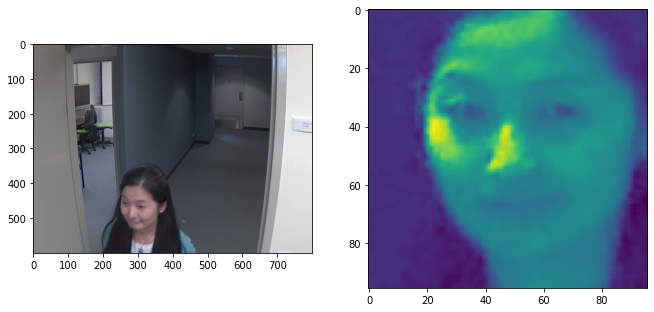

In [ ]:
# Find a match for user given image
usrObj = User()
usrObj.upload('/content/00003257.jpg')
usrObj.get_results()

In [ ]:
!pip install flask_ngrok
!pip install -U flask-cors

In [ ]:
from flask import *
from flask_ngrok import run_with_ngrok
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)

# @app.route('/upload', methods = ['POST','OPTIONS'])
# def upload():  
#     if request.method == 'POST':
#         f = request.files['file']  
#         f.save(f.filename)
#         print(f.filename)
#         # usrObj.upload(/content/+ f.filename)
#         return "File uploaded",200

@app.route('/')  
def upload():  
    return render_template("file_upload_form.html")  


@app.route('/process', methods = ['POST'])  
def process():  
  
  if request.method == 'POST': 
    # print(request.files['file'].filename)
    # f = request.files['file']
    # f.save(f.filename)
    print("hi")
    a=request.form.get('file')
    a
    #model.predict
    return send_file(a, mimetype='image/gif')
    #return render_template("file_upload_form.html",output = "/hello")
    # return a

@app.route("/hello")
def hello():
  return send_file("/content/img935_924_N95.jpg", mimetype='image/gif')

if __name__ == '__main__':  
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://501c6d0f2ca6.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[2021-04-02 10:46:20,591] ERROR in app: Exception on /process [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_reque

hi


In [ ]:
!mv /content/file_upload_form.html /content/templates/